In [21]:
import numpy as np
import matplotlib.pyplot as plt

In [22]:
# Parámetros de simulación
num_bits = 10000
rango_snr_db = np.arange(0, 11, 2)

In [23]:
# Generación de bits aleatorios
def generar_bits(num_bits):
    return np.random.randint(0, 2, num_bits)

In [24]:
# Conversión de SNR de dB a valor lineal
def snr_db_a_lineal(snr_db):
    return 10 ** (snr_db / 10)

In [25]:
# Ruido AWGN
def agregar_ruido_awgn(senal, snr_db):
    snr_lineal = snr_db_a_lineal(snr_db)
    potencia_senal = np.mean(np.abs(senal) ** 2)
    potencia_ruido = potencia_senal / snr_lineal
    ruido = np.sqrt(potencia_ruido / 2) * (np.random.randn(*senal.shape) + 1j * np.random.randn(*senal.shape))
    return senal + ruido

In [26]:
# Modulación ASK
def modular_ask(bits):
    return np.where(bits == 0, -1, 1)

In [27]:
# Modulación FSK
def modular_fsk(bits, tasa_muestreo=10):
    t = np.arange(0, len(bits) * tasa_muestreo) / tasa_muestreo
    return np.cos(2 * np.pi * bits * t[:len(bits)])

In [28]:
# Modulación BPSK
def modular_bpsk(bits):
    return np.where(bits == 0, -1, 1)

In [29]:
# Modulación 16-QAM
def modular_qam(bits):
    bits = bits[:len(bits) // 4 * 4]  # Asegurar múltiplo de 4 bits
    simbolos = np.reshape(bits, (-1, 4))
    mapeo = {0: -3, 1: -1, 2: 1, 3: 3}
    real = np.array([mapeo[int(''.join(map(str, simbolo[:2])), 2)] for simbolo in simbolos])
    imag = np.array([mapeo[int(''.join(map(str, simbolo[2:])), 2)] for simbolo in simbolos])
    return real + 1j * imag, bits  # Retornar señal QAM y bits ajustados

In [30]:
# Función para demodular y calcular la BER
def calcular_ber(bits, bits_detectados):
    # Ajustar longitud de bits_detectados si es necesario
    longitud_minima = min(len(bits), len(bits_detectados))
    bits = bits[:longitud_minima]
    bits_detectados = bits_detectados[:longitud_minima]
    errores = np.sum(bits != bits_detectados)
    return errores / len(bits)

In [31]:
# Simulación de BER para cada esquema de modulación
def simular_ber(esquema_modulacion):
    bits = generar_bits(num_bits)
    
    if esquema_modulacion == 'ASK':
        senal = modular_ask(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'FSK':
        senal = modular_fsk(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'BPSK':
        senal = modular_bpsk(bits)
        funcion_demodular = lambda senal: np.where(senal >= 0, 1, 0)
    elif esquema_modulacion == 'QAM':
        senal, bits = modular_qam(bits)  # Obtener bits redimensionados para QAM
        funcion_demodular = lambda senal: np.concatenate([
            (np.round((senal.real + 2) / 2) > 0).astype(int),
            (np.round((senal.imag + 2) / 2) > 0).astype(int)
        ])
    else:
        raise ValueError("Esquema de modulación no soportado")
    
    ber = []
    for snr_db in rango_snr_db:
        senal_con_ruido = agregar_ruido_awgn(senal, snr_db)
        bits_detectados = funcion_demodular(senal_con_ruido)
        ber.append(calcular_ber(bits, bits_detectados))
    
    return ber

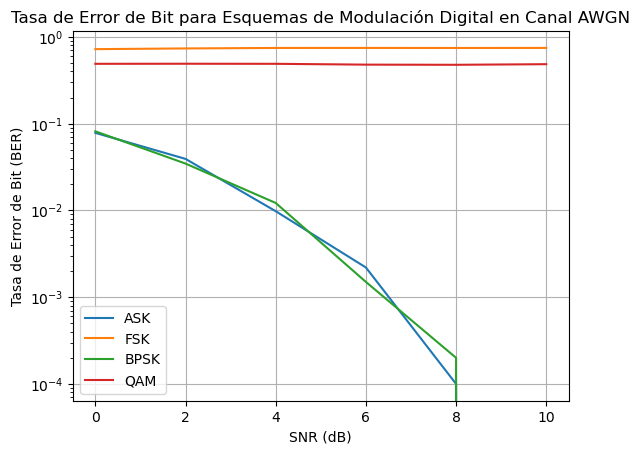

In [ ]:
# Ejecutar simulación para cada esquema de modulación
esquemas_modulacion = ['ASK', 'FSK', 'BPSK', 'QAM']
for esquema_modulacion in esquemas_modulacion:
    ber = simular_ber(esquema_modulacion)
    plt.plot(rango_snr_db, ber, label=esquema_modulacion)
    
# Gráfica de resultados
plt.xlabel("SNR (dB)")
plt.ylabel("Tasa de Error de Bit (BER)")
plt.yscale("log")
plt.title("Tasa de Error de Bit para Esquemas de Modulación Digital en Canal AWGN")
plt.legend()
plt.grid()
plt.show()